In [1]:
# the usual imports
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
import statsmodels.datasets
import plotly.graph_objects as go

# imports from the package
import particles
from particles import state_space_models as ssm
from particles import kalman
from particles import distributions as dists

from utils import *

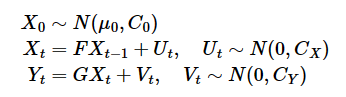

In [2]:
# エルニーニョデータ
df = statsmodels.datasets.elnino.load().data
df = pd.DataFrame(
    index=pd.date_range(start="1950/01", end="2010/12", freq="MS"),
    columns=["Temperature"],
    data=df.drop("YEAR", axis=1).values.flatten()
)

# 人工的に欠測値を作成
df["Temperature_missing"] = df["Temperature"]
df["Temperature_missing"].iloc[100:150] = np.nan # 50か月欠損
df["Temperature_missing"].iloc[550:600] = np.nan # 50か月欠損

In [3]:
config = {
    "yaxis": {"min": None, "max": None}
}
traces = {
    "data": {
        "x": df.index,
        "y": df["Temperature"],
        "color": "blue",
        "fill": None
    },
    "missing data": {
        "x": df.index,
        "y": df["Temperature_missing"],
        "color": "red",
        "fill": None
    }
}
request = {"config": config, "traces": traces}
fig = plot(request)
fig.show()

In [18]:
#%% 季節調整モデル
# データの長さ
T = len(df)

# 状態方程式の行列
F_trend = np.array(
    [[1]]
)
F_seasonal = np.array(
    [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
     [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
     [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
     [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
     [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
     [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
     [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
     [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
     [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0]]
)
F = make_diag_stack_matrix([F_trend, F_seasonal])

# 観測方程式の行列
G_trend = np.array([[1]])
G_seasonal = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
G = make_hstack_matrix([G_trend, G_seasonal])

# システムノイズ
CX = np.array(
    [[ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]
)

# 観測ノイズ
CY = np.array([1])

In [20]:
ssm = kalman.MVLinearGauss(F=F, G=G, covX=CX, covY=CY)

In [22]:
data = df["Temperature"]
kf = kalman.Kalman(ssm=ssm, data=data)
kf.filter()

In [28]:
trend_means = [filt_t.mean[0] for filt_t in kf.filt]
seasonal_means = [filt_t.mean[1] for filt_t in kf.filt]

In [29]:
config = {
    "yaxis": {"min": None, "max": None}
}
traces = {
    "observed_data": {
        "x": df.index,
        "y": data,
        "color": "blue",
        "fill": None
    },
    "trend": {
        "x": df.index,
        "y": trend_means,
        "color": "red",
        "fill": None
    },
    "seasonal": {
        "x": df.index,
        "y": seasonal_means,
        "color": "red",
        "fill": None
    }
}
request = {"config": config, "traces": traces}
fig = plot(request)
fig.show()